*Arman Khoshnevis*

*Max Ponce*

# Timing, Testing, and Profiling

Before we make changes to any code, we should establish a baseline with **timing measurements** and **tests**. A baseline timing measurement lets us compare any changes to assess improvement (or degradations!) while tests ensure that our code remains accurate. Improving code performance doesn't help us if we introduce bugs!
Best practice would be to implement a [unit test](https://www.techtarget.com/searchsoftwarequality/definition/unit-testing) for every unique feature of a program, but any testing is better than none.

After establishing a baseline, we should employ **profiling** to uncover the parts of our program that would benefit most from optmization. We probably already have an idea as to what parts of our code are the slowest. Profiling lets us test our hypotheses. For instance, if we have a function that is executed only once and a function that is executed a thousand times, we might assume it's best to optimize the function executed a thousand times. But profiling might reveal that the function executed only a single time dominates our "wall time" (the real-world time that passes as measured by a clock on the wall).

---
## Timing Code Execution

We'll cover two ways of timing blocks of code. Each is slightly different and has its own pros and cons. You're free to choose which method you prefer for your work in this class, and can switch between methods as you prefer. You are also welcome to research alternative methods.

The methods we will cover are:
* the `timeit` magic command
* the `time` module

### Timeit magic

Jupyter notebooks allow for special, non-Python commands that act on a given line or cell. These commands are called "magic."

One magic command is `timeit`, which provides a quick way for measuring the performance of some code.

The `timeit` magic command can either be used on a single line with `%timeit` or on a whole cell with `%%timeit`.

Execute the code below to see the output.

In [2]:
import numpy as np

%timeit np.ones(10) # time just array creation

1.06 μs ± 108 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [3]:
%%timeit # time whole cell; list creation and append loop
lst = []
for i in range(100):
    lst.append(i) 

1.7 μs ± 68.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


Both versions of the `timeit` magic command report the average runtime and its standard deviation.

The output also references **loops** and **runs**. The `timeit` command will execute our code multiple times (the loops) during one measurement to increase accuracy. It will then repeat this timing measurement over multiple runs in order to measure the mean and standard deviation.

An example of two runs with four loops each is shown in the diagram below. 

![Diagram explaining loops and runs as used by timeit](loop-run-diagram.png)

One full execution of a hypothetical program is represented by the orange blocks. The program is looped over and executed four times per run. The execution time measured by each run $r_1$ and $r_2$ would then be $(t_1-t_0)/4$. These runs can then be used to report an average runtime and a standard deviation. For example, the average runtime of the program represented by the orange block is $(r_1 + r_2) / 2$

Using repeated runs for measurement are important because the CPU will not be executing our code 100% of the time. It will instead switch between operating system tasks and other programs, such as the web browser you are running this notebook in. You will never be able to prevent this "context switching" but it can cause variation in timing measurements. Using multiple runs lets us statistically characterize the performance of our program.

On the other hand, using multiple loops per run let's us better measure the run time of a program, particularly if it is very short. Timing measurements don't have infinite precision and there is a minimum time difference that can be measured.

---
#### Exercises

1. Add the `timeit` magic command to the following code. **Don't** time how long it takes to import the `time` module. We're using `time.sleep` to make the computer pause for 1 second and simulate a longer-running piece of code.

In [4]:
import time

%timeit time.sleep(2)

2 s ± 8.21 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


2. How does the number of loops and runs compare to the `timeit` examples above? Why is the number of loops different?

### Answer
The number of runs and loops depend on how long the script takes to execute. In the above way of coding, it is decided automatically by Python to ensure the total measured time is long enough but not too long. However, it is possible to specify the number of runs and loops by `-r` and `-n` options, respectively.

---
### Time Module

Often in this course we'll want to see how execution time changes as we adjust various parameters and then plot the results. Though the `timeit` magic command makes timing a short piece of code easy, it is tedious to use for this kind of analysis.

As an alternative, we can use the `time` module. This module is able to return timestamps. We can use the difference in these timestamps to measure our code's execution time.

Timing execution in this way isn't as robust as using `timeit` because it doesn't automatically perform multiple loops or runs, but it does make it easier to repeat timing measurements within a `for` loop, for example. We can manually decided to find the average and standard deviation if we wish.

There are two functions we might consider using, depending on our desired precision:

* `time.perf_counter`
* `time.perf_counter_ns`

While `time.perf_counter` returns time in (fractional) seconds, `time.perf_counter_ns` returns the time in nanoseconds. For shorter run times, it's better to use `time.perf_counter_ns` to avoid floating point errors. Both of these functions return timestamps that only make sense when compared against each other.

These functions measure the amount of real time (or **wallclock time**) that has passed, which includes the time that passes when the process sleeps so the CPU can switch to other tasks. The amount of time the CPU spends on other tasks will introduce some variability into the resulting execution time. Both of these `perf_counter` functions return timestamps with the highest precision measurable by the computer.

Run the following cell to see `perf_counter` in action.

In [15]:
start = time.perf_counter()

lst = []
for i in range(100):
    lst.append(i)

end = time.perf_counter()

print("This code took", (end - start), "seconds")

This code took 5.7538971304893494e-05 seconds


---
#### Exercises

1. Rerun the `perf_counter` example a couple of times and notice the variation in timing measurements. This is what `timeit` is trying to account for by using multiple runs. What's the highest value you've seen? What's the lowest?

### Answer

The highes and lowest run time values observed after multiple times of running the code are 8.725933730602264e-05 (s) and 5.7369470596313477e-05 (s), respectively. The highest occured in the first attempt of running the code and the lowest happened in the 8th attempt. My expectation was to start with higher values and go down in the duration to hit a plateau. 

2. The `perf_counter` example runs the same code as the `%%timeit` example from above. Compare the timing measurements returned by these two measurements. Are they different? Which seems to be higher? Google something like "perf_counter vs timeit" to do some research on subtle differences between these approaches that might explain this difference.

### Answer

`perf_counter` results tend to be higher by an order of magnitude compared to `timeit` results. The reasons for this discrepancy are

- `timeit` runs the code multiple times to accounts for system variations and background processes. Hence, it provides more reliable results compared to its counterpart.
- `timeit` disables the garbage collector during timing to prevent its impact on results.
- `perf_counter` usually runs the code on cold cache, while `timeit` performs the code multiple times so the code/variables are hot. 

Regarding the cold/hot cache, my take away is that if the data (or even the machine code) is in the CPU memory (cache), that is hot cache and its access is much faster than cold cache, in which the data is not cached in.

Regarding the garbage collector, it is run occasionally (not deterministically) in the background to clean-up obejcts in the memory that are not referrenced.

3. Time the following block of code for array sizes `n` of 10, 100, 1000, and 10000. Use both `perf_counter` in a `for` loop and `timeit`, and plot both results. Make sure to include **axis labels and a legend**. Put your code in the following cells as indicated by the comments.

```python
arr = np.arange(n) # change n
csum = 0
for num in arr:
    csum += num
```

In [16]:
# perf_counter in a for loop

time_list_perf = []
for n in [10, 100, 1000, 10000]:
    start = time.perf_counter()
    arr = np.arange(n) # change n
    csum = 0
    for num in arr:
        csum += num
    end = time.perf_counter()
    time_list_perf.append(end - start)

In [34]:
# timeit in a for loop
import timeit

time_list_timeit = []

for n in [10, 100, 1000, 10000]:
    stmt = """
arr = np.arange(n)
csum = 0
for num in arr:
    csum += num
"""
    result = timeit.Timer(stmt, globals={"n": n, "np": np}).repeat(repeat=50, number=1)

    avg_time = sum(result) / len(result)
    time_list_timeit.append(avg_time)


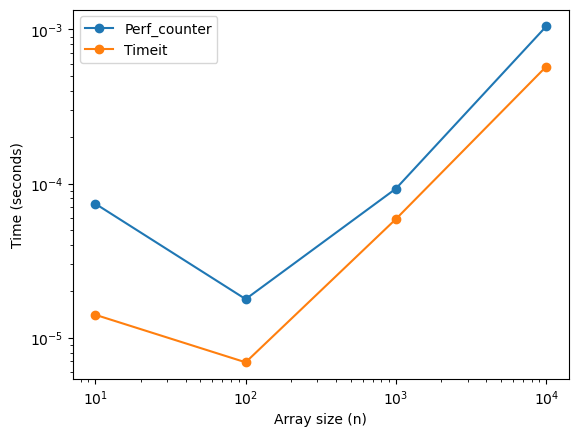

In [35]:
# plot both measurements
import matplotlib.pyplot as plt

plt.loglog([10, 100, 1000, 10000], time_list_perf, 'o-', label='Perf_counter')
plt.loglog([10, 100, 1000, 10000], time_list_timeit, 'o-', label='Timeit')
plt.xlabel('Array size (n)')
plt.ylabel('Time (seconds)')
plt.legend()
plt.show()

4. In what instance would you *personally* prefer to use `timeit`? When would you prefer to use `time.perf_counter`?

### Answer
It seems `timeit` is a more suitable tool to benchmark short code snippets, while `time.perf_counter` is more inline with measuring realistic workflows and realistic timing.

---
## Profiling

"Profiling" ones code means gathering data about how the program is executed. Some common questions that profiling can answer are:

* What part of the code does the program spend the most time in?
* What code represents the slowest part of my program?
* How much memory is my program using?

Answering such questions allows us to identify targets for **optimization**.

Usually, profiling code execution times and memory usage require different tools. We will focus on execution time in this course. In particular, we'll use two magic commands: `prun` and `lprun`.

For this exercise, we'll use a program to calculate [Julia sets](https://en.wikipedia.org/wiki/Julia_set) modified from [High Performance Python by Gorelick & Ozsvald](https://github.com/mynameisfiber/high_performance_python_2e/tree/master/02_profiling).

### The Julia Set

Julia sets are defined by picking a complex point $c$; for instance, $c=-0.62772 - j0.42193$ where $j$ is the imaginary number. For a set of complex coordinates $z$, the coordinate $z$ belongs to the Julia set if the iteration $z^\prime = z^2+c$ remains less than 2. 

The following code applies this test, putting a cap on the maximum number of iterations used to test each coordinate $z$. We save the number of iterations `n_iter` used to test each coordinate $z$. We will use the built-in [`complex`](https://docs.python.org/2/library/stdtypes.html#numeric-types-int-float-long-complex) type for our imaginary numbers.

In [ ]:
def test_julia(zs, c, max_iter):
    """
    Given a complex coordinate c and a list of complex coordinates zs,
    test whether each z in zs belongs to the Julia set defined by c.
    
    Return the number of iterations n_iter needed to determine
    whether or not each z is in the set.
    
    The number of iterations is capped by max_iter.
    """
    output = [0] * len(zs) # create list of zeros with length len(zs)

    for i in range(len(zs)):
        n_iter = 0
        z = zs[i]
        while abs(z) < 2 and n_iter < max_iter:
            z = z * z + c
            n_iter += 1
        output[i] = n_iter
        
    return output

We can then write a function that constructs a grid of $z = x + jy$ coordinates and plots the number of iterations needed to test each $z$. The lightest points belong to the Julia set, while darker points require fewer iterations to exclude them from the set. This is the most common way of visualizing Julia sets.

In [37]:
def calc_julia_set(c, x1, x2, y1, y2,
                   width=1000, max_iterations=300, draw_output=False):
    """
    Create a list of complex coordinates zs where z = x + iy
    and test whether these points belong to the Julia set
    defined by c. Optionally plot the resuling set.

    Returns the sum of iterations needed to test all zs.
    
    The lower and upper bounds of x and y 
    are defined by x1, x2, y1, and y2.
    The width controls the number of coordinates 
    between the minimum and maximum.
    Control the maximum number of iterations for testing each
    coordinate z with max_iterations.
    Control plotting with draw_output.
    """
    # Construct lists of x and y (real and imaginary) coordinates
    x_step = (x2 - x1) / width
    y_step = (y1 - y2) / width
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord < x2:
        x.append(xcoord)
        xcoord += x_step

    # Combine x and y into a list of complex z coordinates
    zs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))

    # Print information about dimensionality
    print("Length of x:", len(x))
    print("Total elements:", len(zs))

    # Calculate the Julia set
    output = test_julia(zs, c, max_iterations)

    # Optionally plot the set
    if draw_output:
        plt.pcolormesh(x, y, np.reshape(output, (width, width)))

    return sum(output)

With our functions defined, let's set our parameters:

In [38]:
c_init = complex(-0.62772, -0.42193)
print("c is", c_init)

x_min, x_max = -1.8, 1.8
y_min, y_max = -1.8, 1.8

c is (-0.62772-0.42193j)


For the default `width` and `max_iterations`, we expect `sum(output)` to be 33219980. We can use this to test the correctness of our function as we make changes. 

In [39]:
expected_sum = 33219980

---
#### Exercise

Calculate, display, and verify the Julia set for `c_init` and the x and y bounds defined above.

In [42]:
# Calculate Julia set
sum_output = calc_julia_set(c_init, x_min, x_max, y_min, y_max, width=1000, max_iterations=300, draw_output=False)
print(sum_output)

Length of x: 1000
Total elements: 1000000
33219980


---
### Profiling the Julia Set Calculation

Programs are often long and complex. A developer following best practices will split such a program into functions; but even if the developer doesn't, a program will still likely rely on a number of functions built into Python and any imported modules (such as NumPy). A **function-by-function** profiler such as the magic command `prun` will return timing information for all functions used in a program, both user-defined and otherwise. This timing information will also include the number of times a program was called. 

It's generally safe to assume that any function not written by you -- that is, a function in a module or built into Python -- is already optmizied.

After identifying *functions* that could benefit from optimization, you may want to turn to a **line-by-line** profiler such as the `%lprun` magic command provided by the `line_profiler` module (aka "kernprof"). **This module can also be invoked inside [scripts](https://kernprof.readthedocs.io/en/latest/) run from the command line.** Such a profiler will give you information on the performance of individual lines of code.

We'll practice parsing the output of `%prun` and `%lprun`. If you ever want more information about these magic commands, you can run them with a question mark; e.g. `%prun?`

---
#### Exercises

1. Before we start, which function used by `calc_julia_set` do you think consumes the most time? Remember that even a short function called many times can contribute significantly to the overall wall time.

### Answer
Test julia and, in particular, its nested for and while loops.

2. Use `%prun` to profile `calc_julia_set` function-by-function. Disable drawing to see fewer functions. Can you identify the user-defined functions?

In [47]:
# Profile calc_julia_set with prun
%prun -l 20 calc_julia_set(c_init, x_min, x_max, y_min, y_max, width=1000, max_iterations=300, draw_output=False)

Length of x: 1000
Total elements: 1000000
 

         35223354 function calls (35223345 primitive calls) in 8.212 seconds

   Ordered by: internal time
   List reduced from 208 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    3.872    3.872    5.702    5.702 3305798086.py:1(test_julia)
 34219980    2.561    0.000    2.561    0.000 {built-in method builtins.abs}
        6    1.341    0.223    1.986    0.331 {method 'poll' of 'select.epoll' objects}
        6    0.170    0.028    2.373    0.395 selectors.py:435(select)
        1    0.097    0.097    0.147    0.147 {method 'execute' of 'sqlite3.Connection' objects}
  1002011    0.073    0.000    0.073    0.000 {method 'append' of 'list' objects}
        2    0.048    0.024    0.073    0.036 {method '__exit__' of 'sqlite3.Connection' objects}
       23    0.027    0.001    0.041    0.002 socket.py:623(send)
        1    0.007    0.007    5.713    5.713 <string>:1(<module>)
        1    0.006    0.006    0.565    0.565

3. Explain what each of the columns means. In particular, what is the difference between `totttime` and `cumtime`? Notice the total run time near the top of the output. Google is allowed!

### Answer
- `ncalls`: Number of times the function was called. In case of having two numbers, separated by `\`, the first number refers to the total number of calls, while the second number refers to the number of primitive (non-recursive) calls.
- `tottime`: Total time spent in the function, NOT including time spent in sub-functions.
- `percall`: Literally `tottime / ncalls`.
- `cumtime`: Cumulative time spent in the function, INCLUDING time spent in sub-functions.
- `percall`: Literally `cumtime / ncalls`. In the case of having the number of primitive (non-recursive) calls, that is the number in the denomenator.

4. The output says functions are ordered by "internal time." What do you think "internal time" is referring to?

### Answer
`tottime` is also called *internal time.* Therefore, the output of `prun` is sortted by the order to `tottime` column.

5. The `lprun` magic command works a little differntly than `prun`. Since it is provided by a module, we must first load it with `%load_ext`. Then, we must specify a function name with the `-f` argument. We can specify multiple functions by using `-f` multiple times, but `lprun` will *only* profile the functions we specify. Modify the following cells to profile **the user-defined function that `prun` ranked as taking the most internal time**.

In [48]:
# lprun is an external magic command
%load_ext line_profiler

# Profile calc_julia_set; EDIT THE LINE BELOW
%lprun -f test_julia calc_julia_set(c_init, x_min, x_max, y_min, y_max)

Length of x: 1000
Total elements: 1000000


Timer unit: 1e-09 s

Total time: 34.2347 s
File: /tmp/ipykernel_3438687/3305798086.py
Function: test_julia at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def test_julia(zs, c, max_iter):
     2                                               """
     3                                               Given a complex coordinate c and a list of complex coordinates zs,
     4                                               test whether each z in zs belongs to the Julia set defined by c.
     5                                           
     6                                               Return the number of iterations n_iter needed to determine
     7                                               whether or not each z is in the set.
     8                                           
     9                                               The number of iterations is capped by max_iter.
    10                                 

6. Explain what each of the columns mean.

### Answer
- `Line #`: The line number in the file.
- `Hits`: The number of times that line was executed.
- `Time`: The total amount of time spent executing the line in the timer's units. In the header information before the tables, a line "Timer unit:" can be seen, which gives the conversion factor to seconds.
- `Per Hit`: The average amount of time spent executing the line once in the timer's units.
- `% Time`: The percentage of time spent on that line relative to the total amount of recorded time spent in the function.
- `Line Contents`: The actual source code.

7. Explain the different number of "Hits" for each line. Why do some lines hit 1 million times? Why do some hit more? Others only once?

### Answer
If the line is inside a loop or an if/while condition, it will be executed different number of times.

For instance, line 13 is executed 1000001. 1 time for the loop initialization and the remaining is equal to `width` (1000) * `width` (1000), which is the same as the length of the `zs`.

8. Which line do you think is the best target for optimization? Justify using the stats provided by `lprun`.

### Answer
Line 16 (while abs(z) < 2 and n_iter < max_iter:) is the best first target, as it takes the largest share of time: 36.8%. Next line, 17, is the second best target as it takes the second largest share of time.

---
## Application: Improving the Julia Set

We've learned multiple ways to time and profile our code and we've seen one simple way of testing the Julia set program. Now, you'll employ these skills to improve the wall clock time of the Julia set program.  Create new cells as needed to complete these tasks.

1. First, perform a timing measurement of `calc_julia_set` to establish a baseline. You can either include the plotting stage or not, but whatever option you choose, you should be consistent.

In [49]:
# Code here
%timeit calc_julia_set(c_init, x_min, x_max, y_min, y_max, width=1000, max_iterations=300, draw_output=False)

Length of x: 1000
Total elements: 1000000
Length of x: 1000
Total elements: 1000000
Length of x: 1000
Total elements: 1000000
Length of x: 1000
Total elements: 1000000
Length of x: 1000
Total elements: 1000000
Length of x: 1000
Total elements: 1000000
Length of x: 1000
Total elements: 1000000
Length of x: 1000
Total elements: 1000000
5.98 s ± 272 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Answer
5.98 s ± 272 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

2. You've already identified the ideal candidate for optimization in the previous section: the statement `while abs(z) < 2 and n_iter < max_iter`. This statement is evaluating two conditions on the same line. Which expression is faster to evaluate, `abs(z) < 2` or `n_iter < max_iter`? Why do you think that is?

### Answer
`n_iter < max_iter` is significantly faster. It is a simple comparison, which a typically regarded as a fast operation for a CPU. On the other hand `abs(z) < 2` requries the evaluation of the magnitude of a complex number, which involves multiple steps, and hence, it is much slower.

3. An important part of profiling and refactoring is developing and testing hypotheses. Currently, the `while` statement evaluates `abs(z) < 2` even if the loop is on its final iteration. This represents unnecessary work which we might be able to remove for a performance gain.
Before class you were asked to review [Python Operator Precedence](https://introcs.cs.princeton.edu/python/appendix_precedence/). 
How can you use this information to rewrite the `while` statement and avoid unnecessary work?

### Answer
If the `n_iter < max_iter` condition is evaluated first, it will turn out to be `False` already and there will be no need to evaluate `abs(z) < 2` condition, which is way more time consuming.

4. Rewrite `test_julia` (ideally making a renamed copy) to include the optimization you came up with above. Update `calc_julia_set` as needed.

In [50]:
def test_julia_modified(zs, c, max_iter):
    """
    Given a complex coordinate c and a list of complex coordinates zs,
    test whether each z in zs belongs to the Julia set defined by c.
    
    Return the number of iterations n_iter needed to determine
    whether or not each z is in the set.
    
    The number of iterations is capped by max_iter.
    """
    output = [0] * len(zs) # create list of zeros with length len(zs)

    for i in range(len(zs)):
        n_iter = 0
        z = zs[i]
        while n_iter < max_iter and abs(z) < 2:
            z = z * z + c
            n_iter += 1
        output[i] = n_iter
        
    return output

5. Test your updated version of `calc_julia_set` to ensure your changes to `test_julia` didn't change the results.

In [51]:
sum_output = calc_julia_set(c_init, x_min, x_max, y_min, y_max, width=1000, max_iterations=300, draw_output=False)
print(sum_output)

Length of x: 1000
Total elements: 1000000
33219980


6. Time your updated version of `calc_julia_set`. What was the result of testing our hypothesis?

In [52]:
%timeit calc_julia_set(c_init, x_min, x_max, y_min, y_max, width=1000, max_iterations=300, draw_output=False)

Length of x: 1000
Total elements: 1000000
Length of x: 1000
Total elements: 1000000
Length of x: 1000
Total elements: 1000000
Length of x: 1000
Total elements: 1000000
Length of x: 1000
Total elements: 1000000
Length of x: 1000
Total elements: 1000000
Length of x: 1000
Total elements: 1000000
Length of x: 1000
Total elements: 1000000
5.69 s ± 242 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


5.69 s ± 242 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

~0.3 sec improvement, which is quite considerable given the minor change applied to the code.

## For Next Class

Read:

* Read **all pages** of this overview on the [basics of the CPU](https://www.bbc.co.uk/bitesize/guides/zws8d2p/revision/1).
* Watch [this video](https://thecrashcourse.com/courses/data-structures-crash-course-computer-science-14/) on data structures. This video is not specific to Python. The first roughly 6 minutes are the most relevant for our next class, but you may find all of it interesting and informative.
* Read the accompanying PDF on Lists and Tuples to understand how these data structures function under the hood.
* **If you've never used NumPy,** I suggest reading the [beginner guide](https://numpy.org/doc/stable/user/absolute_beginners.html).